# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2022

Original von S. Suter, angepasst für das HS22 von S. Marcin

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Name hier eintragen</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: 1) Die Daten stehen uns für Forschungs- und Bildungszwecke zur Verfügung, 2) wir dürfen die Daten nicht an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio
import numpy as np

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

images = np.empty([4,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename and '1_slice' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            im = imageio.imread(f.name)
            names.insert(idx,f.name[-17:-4])
            images[idx,:,:] = im
            print (names[idx], im.shape)
            idx += 1
            
print(images.shape)

/var/folders/9d/4tljkqh948z6_bfh9n2f6qnr0000gn/T/ipykernel_11848/1139857802.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(f.name)


m3-1_slice145 (256, 170)
m4-1_slice145 (256, 170)
m6-1_slice145 (256, 170)
m1-1_slice145 (256, 170)
(4, 256, 170)


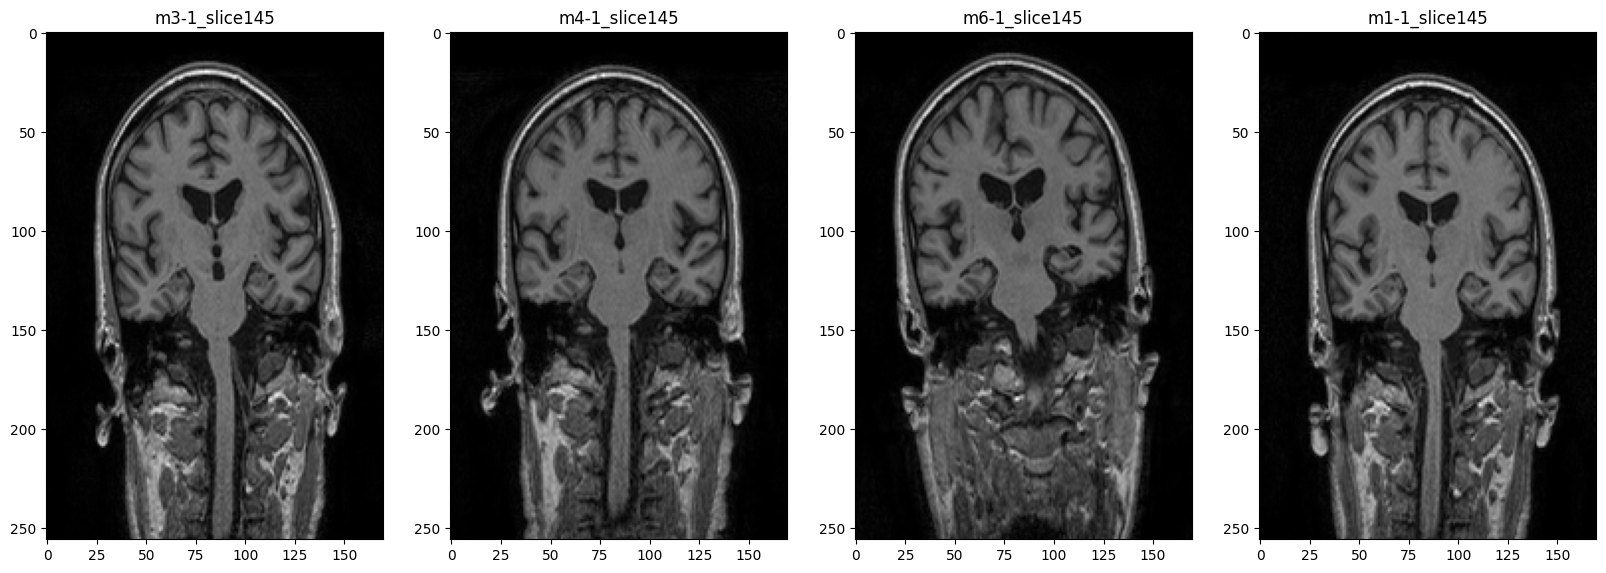

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
im = images[0]
im = im -im.min() / im.max() - im.min() # normalize data 
u,s,vt = np.linalg.svd(im, full_matrices=False)

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [5]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


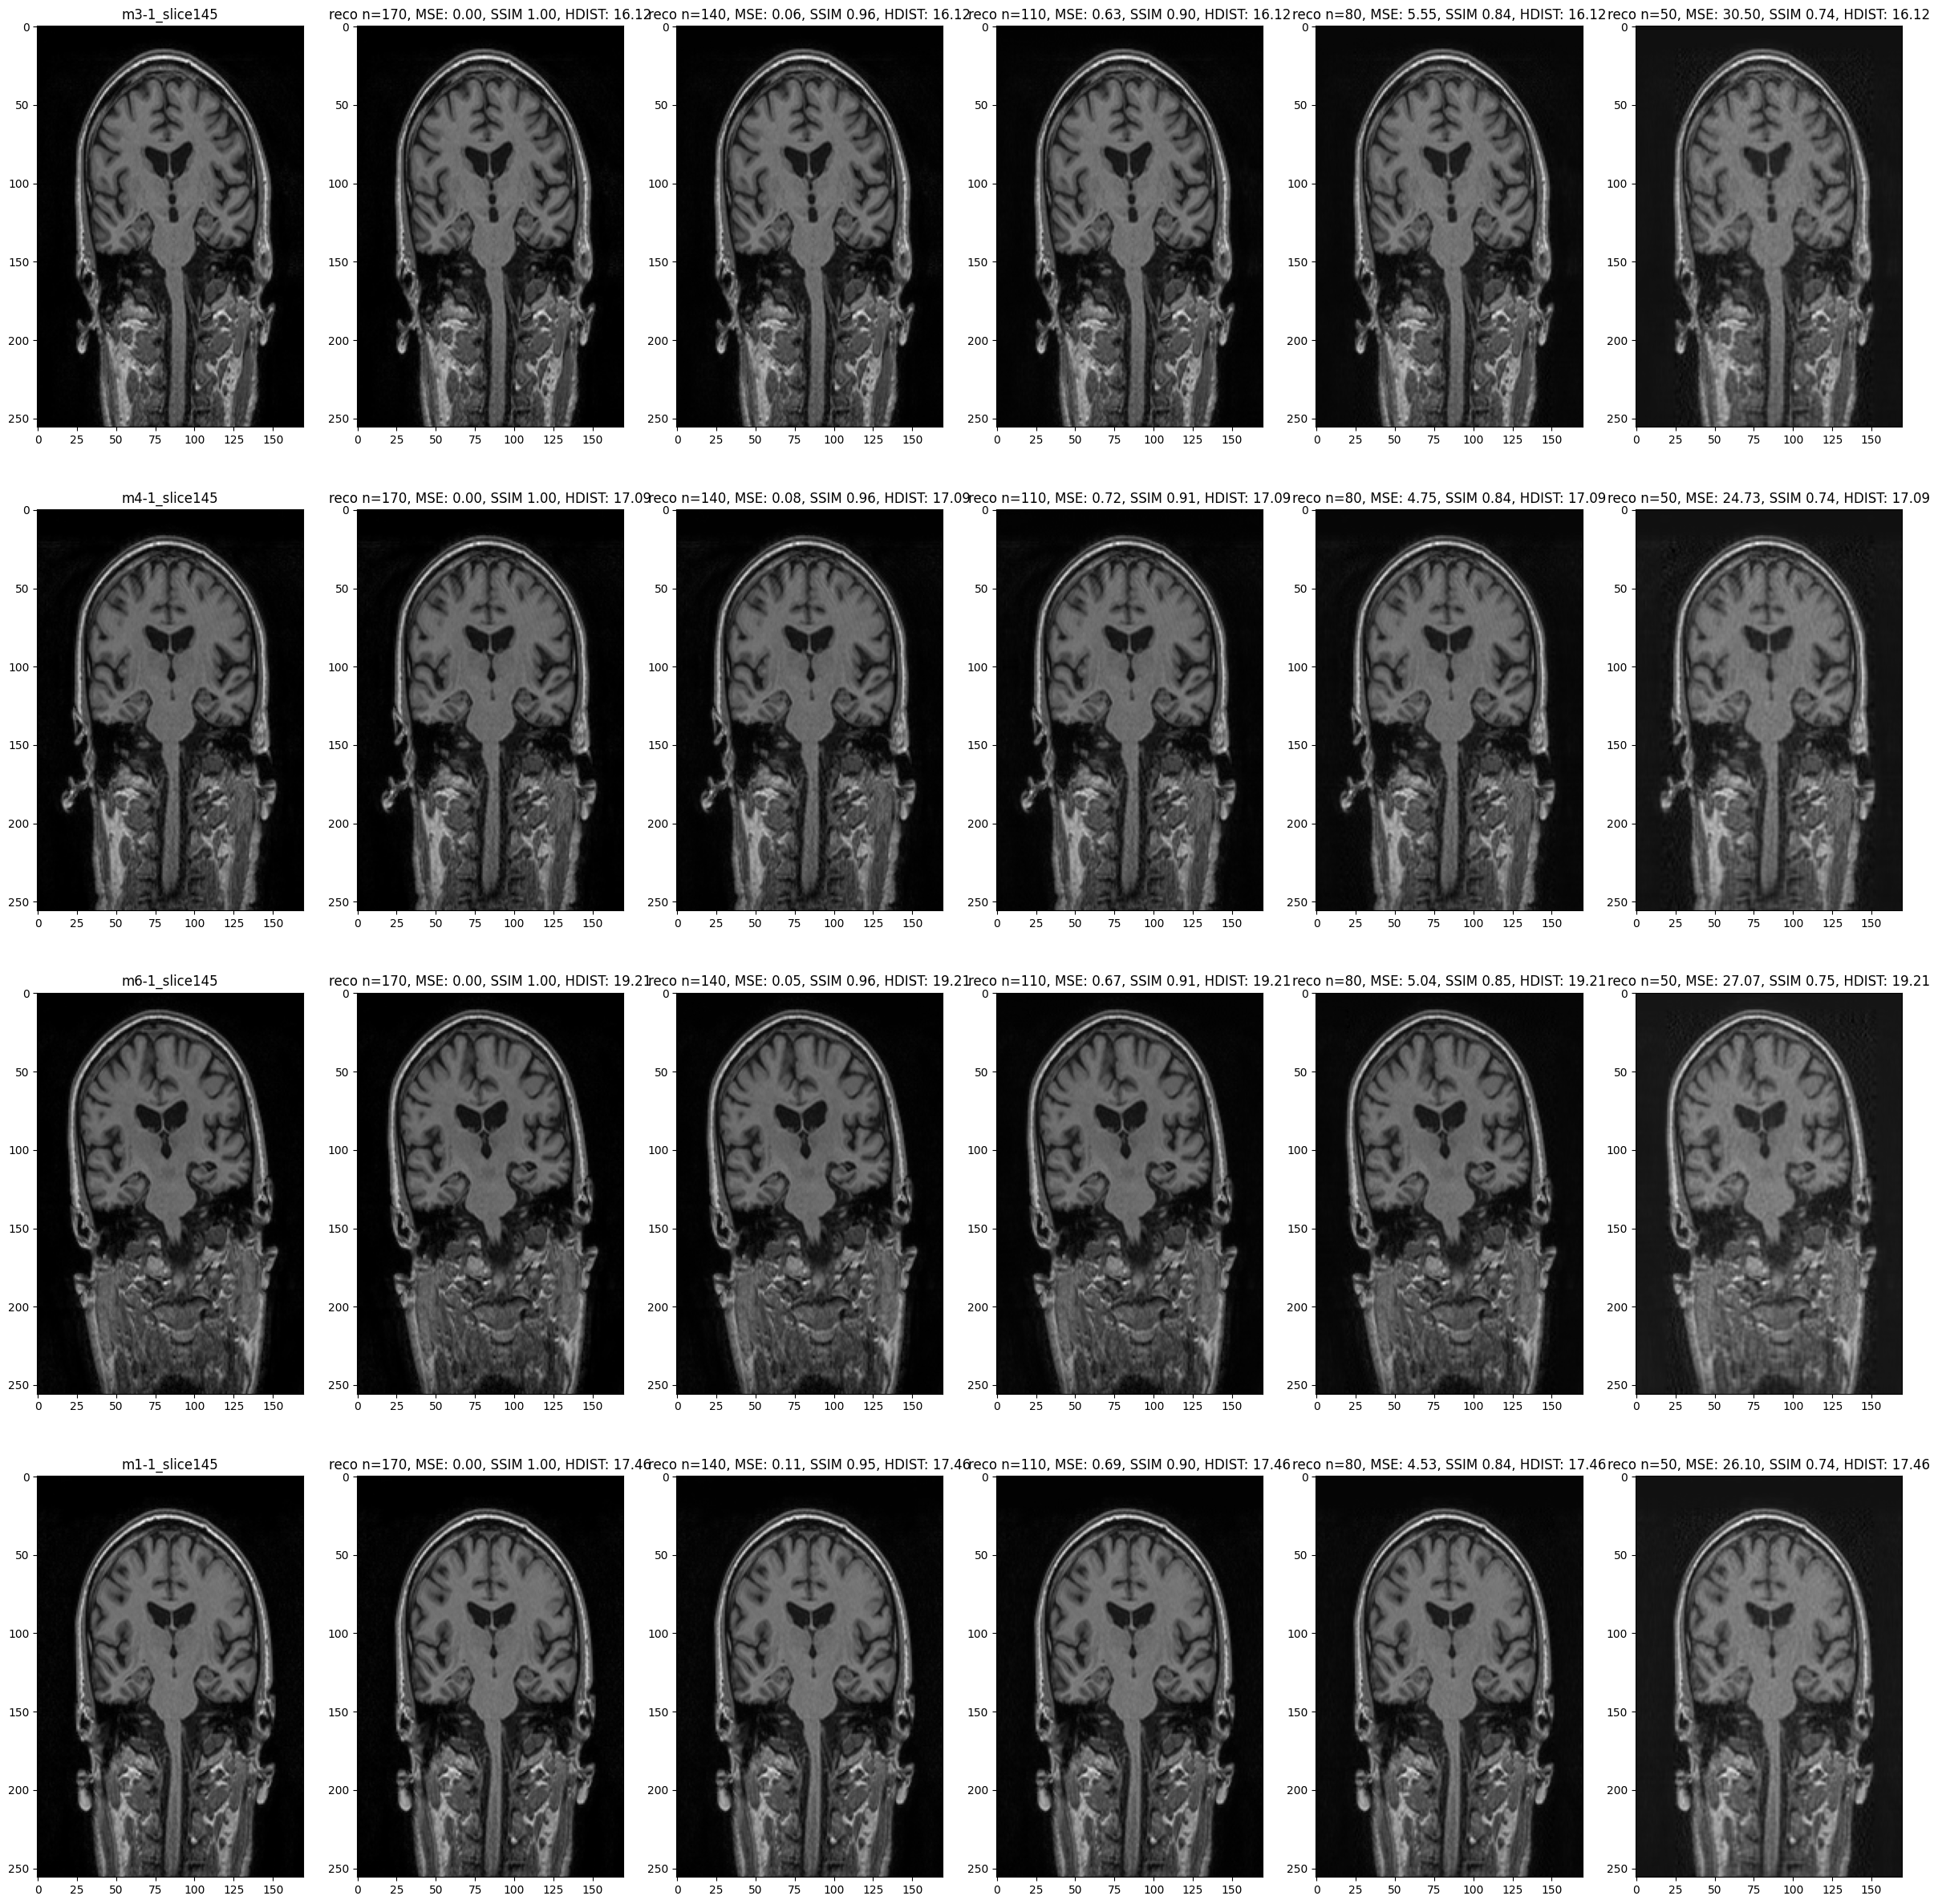

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im -im.min() / im.max() - im.min()    
    u,s,vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)

        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))

### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

$a_{mn} = \sum\limits_{r=1}^p u_{mp} s_{p} vt_{pn}$

In [8]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], u.shape[1]))
    
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            for sv in range(k):
                reco[i, j] += u[i, sv] * s[sv] * vt[sv, j]            
    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], u.shape[1]))
    
    for i in range(u.shape[0]):
        for j in range(u.shape[1]):
            reco[i, j] = u[i, 0:k] * s[0:k] @ vt[0:k, j]
    ### END SOLUTION

    return reco

In [10]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], u.shape[1]))

    for sv in range(k):
        reco += np.outer(u[:, sv], vt[sv, :]) * s[sv]
 
    ### END SOLUTION

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [11]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.einsum('ij,j,jk->ik', u[:, :k], s[:k], vt[:k, :])
    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [12]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k, :]
    ### END SOLUTION

    return reco

In [13]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    s = np.reshape(s, (len(s), 1))
    reco = u[:, :k] @ (s[:k] * vt[:k, :])

    ### END SOLUTION

    return reco


#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

##### 2.4.1 Quantitativer Vergleich der Rekonstruktionen

In [22]:
### BEGIN SOLUTION
u, s, vt = np.linalg.svd(im, full_matrices=False)

k = 3

reco = reconstruct_svd(u, s, vt, k)

np.testing.assert_almost_equal(reco, reconstruct_svd_for_loops1(u, s, vt, k))
np.testing.assert_almost_equal(reco, reconstruct_svd_for_loops2(u, s, vt, k))
np.testing.assert_almost_equal(reco, reconstruct_svd_for_loops3(u, s, vt, k))

np.testing.assert_almost_equal(reco, reconstruct_svd_einsum1(u, s, vt, k))

np.testing.assert_almost_equal(reco, reconstruct_svd_broadcast1(u, s, vt, k))
np.testing.assert_almost_equal(reco, reconstruct_svd_broadcast2(u, s, vt, k))
### END SOLUTION

##### 2.4.2 Qualitativer Vergleich der Rekonstruktionen

In [62]:
def qualitative_comparison_reconstruction(func1, func2, im, k_values):
    assert len(k_values) == 3

    fig, axs = plt.subplots(2, 4, figsize=(20,14))

    axs[0,0].imshow(im, cmap='gray')
    axs[0,0].set_title(names[0])
    axs[1,0].imshow(im, cmap='gray')
    axs[1,0].set_title(names[0])

    u,s,vt = np.linalg.svd(im, full_matrices=False)

    for i, k in enumerate(k_values):
        reco = func1(u, s, vt, k)
        axs[0, i+1].imshow(reco, cmap='gray')
        axs[0, i+1].set_title(f"reco n={k}, {calculate_metrics(im, reco)}")

        reco = func2(u, s, vt, k)
        axs[1, i+1].imshow(reco, cmap='gray')
        axs[1, i+1].set_title(f"reco n={k}, {calculate_metrics(im, reco)}")

    fig.suptitle(f"{str(func1).split('function ')[1].split(' at')[0]} vs. {str(func2).split('function ')[1].split(' at')[0]}", fontsize=20)

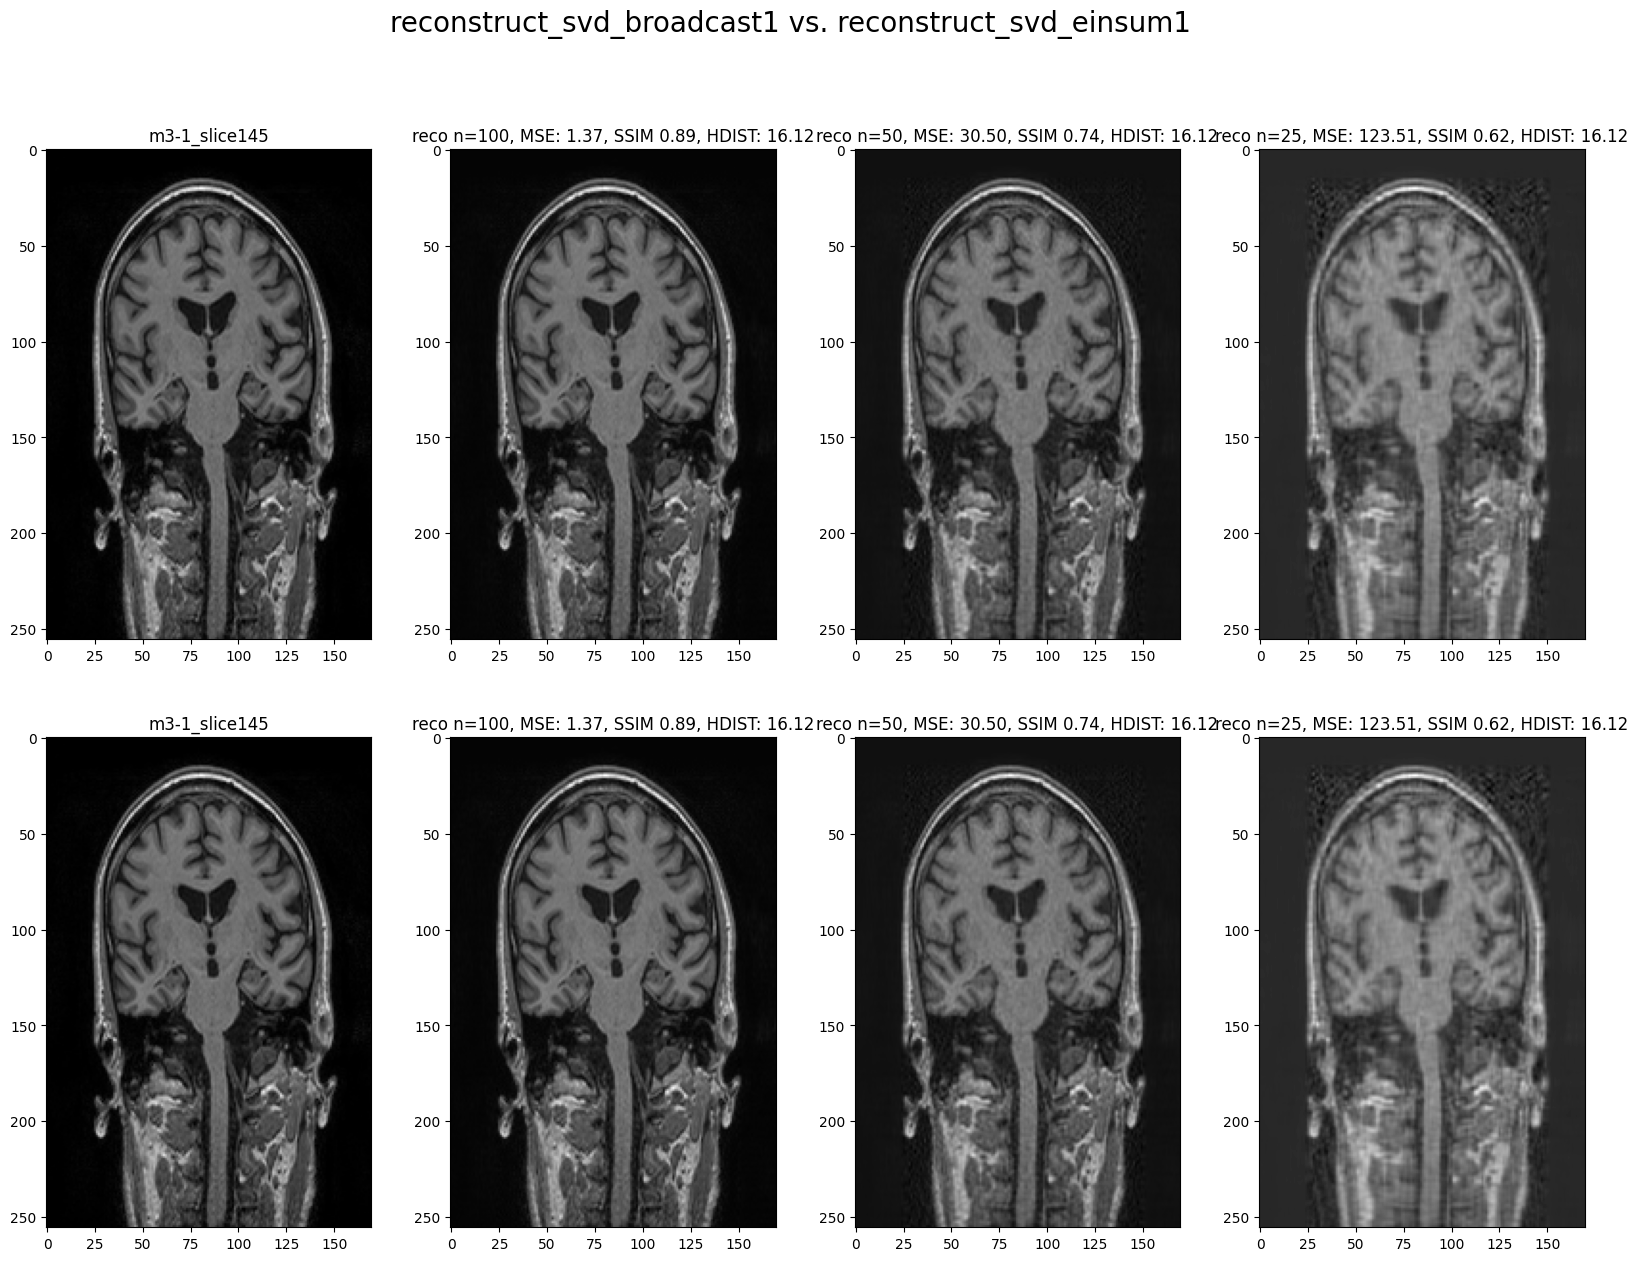

In [63]:
k_values = [100, 50, 25]
im = images[0]
qualitative_comparison_reconstruction(reconstruct_svd_broadcast1, reconstruct_svd_einsum1, im, k_values)

##### 2.4.3 Vergleich Geschwindigkeit

In [102]:
from datetime import datetime
import pickle
import pandas as pd
plt.rcParams['figure.figsize'] = (14, 8)

In [86]:
if "reconstruction_times_single" in os.listdir():
    with open("reconstruction_times_single", "rb") as f:
        times = pickle.load(f)
else:
    func_list = [
        reconstruct_svd,
        reconstruct_svd_broadcast1,
        reconstruct_svd_broadcast2,
        reconstruct_svd_einsum1,
        reconstruct_svd_for_loops1,
        reconstruct_svd_for_loops2,
        reconstruct_svd_for_loops3]

    k_values = list(range(170, 10, -30))

    n_runs = 5

    times = {}

    for i in range(images.shape[0]):
        im = images[i, :, :]
        u, s, vt = np.linalg.svd(im, full_matrices=False)

        for func in func_list:
            func_name = str(func).split("function ")[1].split(" at ")[0]

            for k in k_values:
                for run in range(n_runs):
                    try:
                        times[func_name + f" k={k}"]
                    except KeyError:
                        times[func_name + f" k={k}"] = []
                    
                    start = datetime.now()
                    reco = func(u, s, vt, k)
                    end = datetime.now()
                    times[func_name + f" k={k}"].append((end - start).total_seconds())
    
    with open("reconstruction_times_single", "wb") as f:
        pickle.dump(times, f)

In [108]:
sorted_times = np.array([])
dfs = {}

for func in func_list:
    func_name = str(func).split("function ")[1].split(" at ")[0]
    tmp_df = pd.DataFrame(columns=['k', 'time'])

    for key in times.keys():
        if func_name == key.split(" k=")[0]:
            k_value, t = int(key.split("k=")[-1]), np.mean(times[key])
            tmp_df = pd.concat((tmp_df, pd.DataFrame({'k':[k_value], 'time':[t]})))

    dfs[func_name] = tmp_df

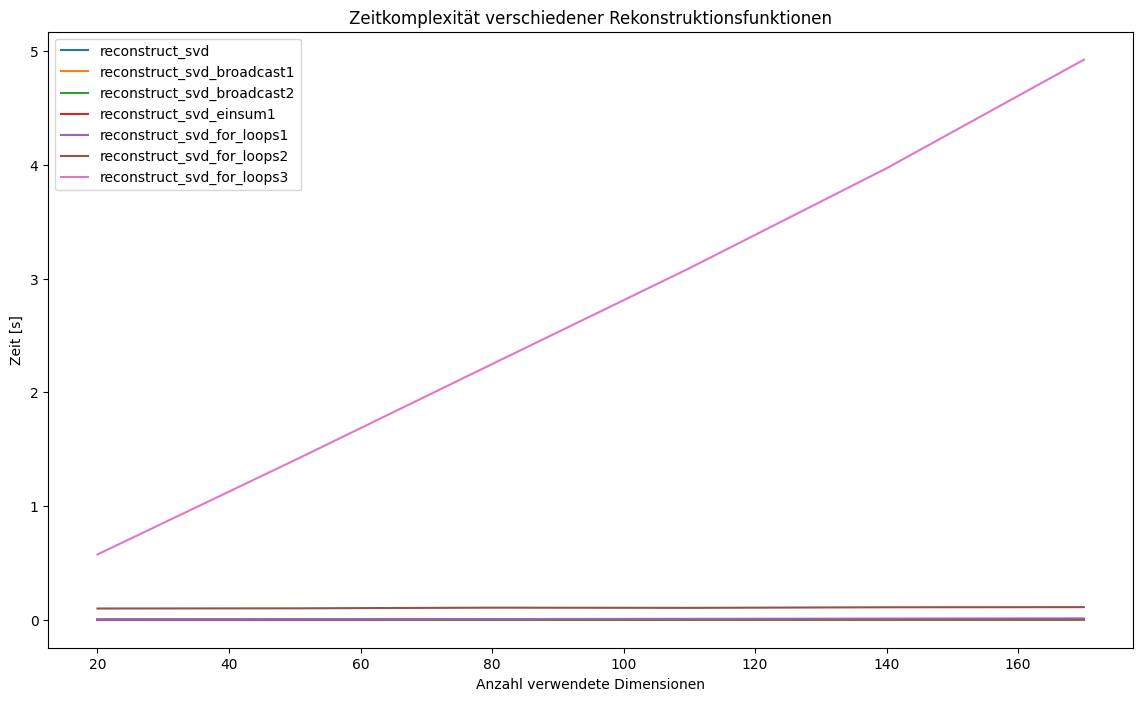

In [124]:
for func in func_list:
    func_name = str(func).split("function ")[1].split(" at ")[0]
    plt.plot(dfs[func_name]['k'], dfs[func_name]['time'], label=func_name)

plt.legend()
plt.title("Zeitkomplexität verschiedener Rekonstruktionsfunktionen")
plt.ylabel("Zeit [s]")
plt.xlabel("Anzahl verwendete Dimensionen")
plt.plot()
plt.show()

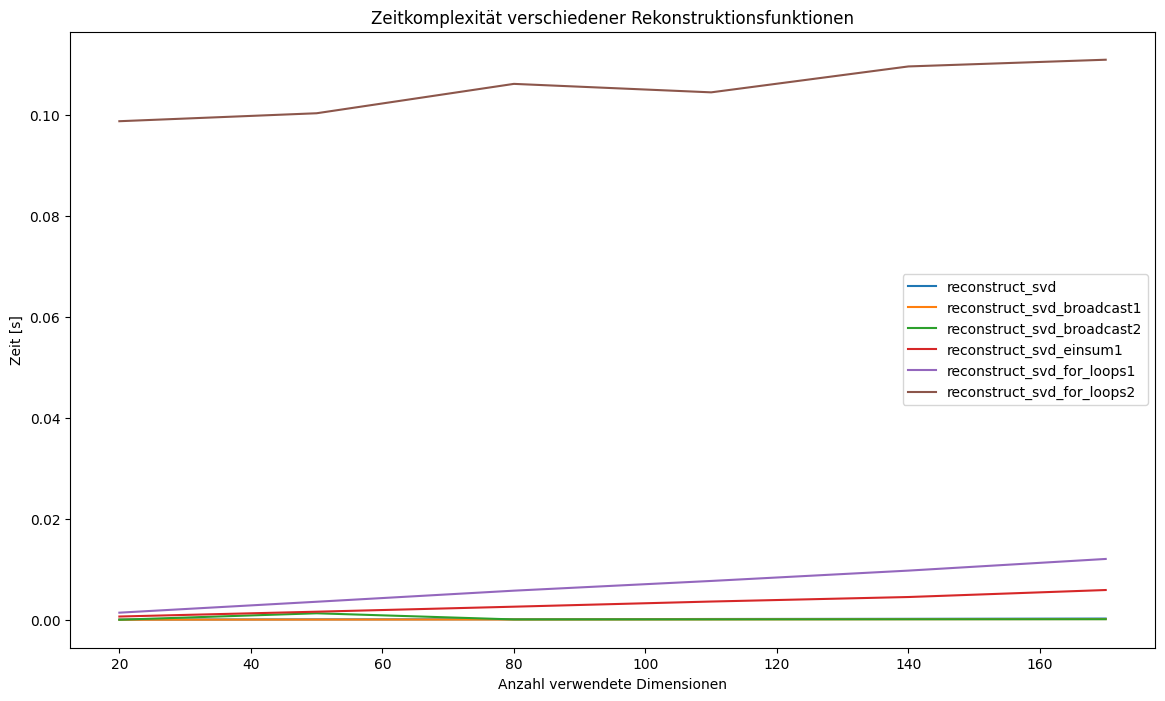

In [125]:
red_func_list = func_list.copy()
red_func_list.remove(reconstruct_svd_for_loops3)

for func in red_func_list:
    func_name = str(func).split("function ")[1].split(" at ")[0]
    plt.plot(dfs[func_name]['k'], dfs[func_name]['time'], label=func_name)

plt.legend()
plt.title("Zeitkomplexität verschiedener Rekonstruktionsfunktionen")
plt.ylabel("Zeit [s]")
plt.xlabel("Anzahl verwendete Dimensionen")
plt.plot()
plt.show()

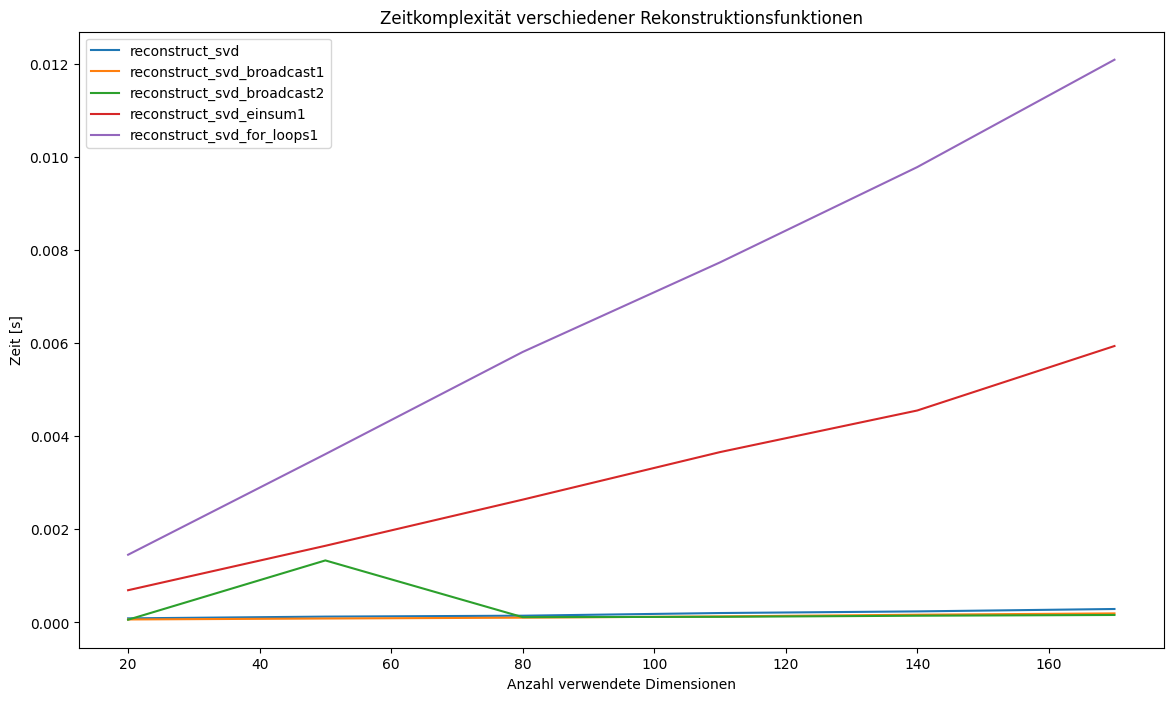

In [126]:
red_func_list.remove(reconstruct_svd_for_loops2)

for func in red_func_list:
    func_name = str(func).split("function ")[1].split(" at ")[0]
    plt.plot(dfs[func_name]['k'], dfs[func_name]['time'], label=func_name)

plt.legend()
plt.title("Zeitkomplexität verschiedener Rekonstruktionsfunktionen")
plt.ylabel("Zeit [s]")
plt.xlabel("Anzahl verwendete Dimensionen")
plt.plot()
plt.show()

In [131]:
ranking = pd.DataFrame(columns=['method', 'avg_time'])

for key in dfs.keys():
    ranking = pd.concat((ranking, pd.DataFrame({'method':[key], 'avg_time':[dfs[key]['time'].mean()]})))    

ranking.sort_values(by="avg_time", ascending=True, inplace=True)

ranking

method  avg_time
0  reconstruct_svd_broadcast1  0.000124
0             reconstruct_svd  0.000181
0  reconstruct_svd_broadcast2  0.000322
0     reconstruct_svd_einsum1  0.003187
0  reconstruct_svd_for_loops1  0.006746
0  reconstruct_svd_for_loops2  0.104990
0  reconstruct_svd_for_loops3  2.702672

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

##### Welche der Implementierungen war am schnellsten?

Die erste Broadcast-Methode war die schnellste Variante. Sehr nahe lag die normale Rekonstruktionsvariante mit der Matrixmultiplikation. Der Unterschied ist sehr klein und nicht signifikant. Starke Abweichungen von den optimierten Varianten wiesen nur die Implementierungen mit den for-Schleifen und der ```np.einsum()``` Operation auf. Der höhere Zeitaufwand bei den for-Schleifen entsteht durch die kubisch, quadratisch, oder linear zunehmende Zeitkomplexität der drei verschiedenen Implementierungen. Bei der ```np.einsum()``` Implementierung liegt dies an der Implementierung der ```np.einsum()``` Funktion. Die Funktion verwendet zwei for-Schlaufen.

##### Was waren deine Beobachtungen während  der Implementierung?

Die Implementierungen, welche for-Schleifen verwenden, waren deutlich langsamer, als die erste, vorgegebene Implementierung. Beim Testen der Funktionen war dies deutlich spürbar. Mit steigender Anzahl Dimensionen wurde dieser Effekt verstärkt. Dies unterstreicht die Bedeutung der Wahl der effizientesten Implementierung für eine gegebene Aufgabe. 

##### Wo können solche Optimierungen sonst noch eingesetzt werden?
Die Optimierung von Matrixmultiplikationen kann viele Vorteile jenseits der SVD-Rekonstruktion haben. Am naheliegensten ist Machine Learning. Viele Machine Learning Algorithmen können durch die Verwendung von Matrixmultiplikationen optimiert werden. Zum Beispiel kann Matrixmultiplikation verwendet werden, um das Skalarprodukt zwischen Vektoren oder Matrizen effizient zu berechnen, was eine Schlüsseloperation in vielen maschinellen Lernalgorithmen ist. Durch die Optimierung von Matrixmultiplikationen können wir auch die Zeit und Ressourcen reduzieren, die für viele andere Arten von numerischen Berechnungen benötigt werden.

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [156]:
import numba

### BEGIN SOLUTION
@numba.njit(parallel=True, cache=True)
### END SOLUTION
def reconstruct_svd_numba(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION
    m, n = u.shape
    reco = np.zeros((m, n))
    for i in numba.prange(k):
        for j in range(n):
            reco[:, j] += u[:, i] * s[i] * vt[i, j]
### END SOLUTION

    return reco

In [162]:
### BEGIN SOLUTION
times = np.array([])
for _ in range(10):
    u, s, vt = np.linalg.svd(images[0], full_matrices=False)
    start = datetime.now()
    reconstruct_svd_numba(u,s,vt,170)
    times = np.append(times, (datetime.now() - start).total_seconds())

print("Zeit Numba-Funktion: ", times.mean())

times = np.array([])
for _ in range(10):
    start = datetime.now()
    reconstruct_svd_for_loops2(u,s,vt,170)
    times = np.append(times, (datetime.now() - start).total_seconds())
print("Zeit Python-Funktion: ", times.mean())
### END SOLUTION

Zeit Numba-Funktion:  0.024706799999999998
Zeit Python-Funktion:  0.10403290000000001


Die beiden folgenden Bilder zeigen den Unterschied zwischen der Implementierung mit den zwei for-Schleifen und der Numba-Implementierung. Es ist klar ersichtlich,dass die Numba-Implementierung um ein Vielfaches schneller ist. Die Numba-Implementierung ist ca. 4-mal schneller, als die Implementierung mit den zwei for-Schleifen. 

<div style="display:flex">
    <img style="width:50%" src="images/for-loops-snakeviz.png">
    <img style="width:50%" src="images/numba-snakeviz.png">
</div>

Es wurde die ersten for-Schleife der Funktion ```reconstruct_svd_numba()``` parallelisiert. Dies ist erkennbar an der verwendeten Funktion ```numba.prange()```. Die zweite for-Schleife wurde nicht parallelisiert, weil die Parallelisierung von verschachtelten Schleifen nicht notwendigerweise zu einer verbesserten Performance führt. Dies liegt an dem erhöhten Overhead, welcher durch Paralellisierung erhöht wird. Deshalb muss immer pro Anwendung evaluiert werden, ob es sich lohnt gewisse Teile eines Programms zu parallelisieren oder nicht. In der nächsten Zelle wird eine weitere Funktion implementiert. Es ist eine Erweiterung der ```reconstrcut_svd_numba()```Funktion. Jedoch werden beide for-Schleifen parallelisiert. Die gemessenen Zeiten bestätigen jedoch, dass sich die Parallelisierung der zweiten for-Schleife nicht lohnt. Die benötigte Zeit für die zweite Funktion ist sogar leicht höher als die gemessene Zeit der ersten Funktion. 

<font color='blue'>Antwort hier eingeben</font>

In [ ]:
import numba

### BEGIN SOLUTION
@numba.njit(parallel=True, cache=True)
### END SOLUTION
def reconstruct_svd_numba2(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION
    m, n = u.shape
    reco = np.zeros((m, n))
    for i in numba.prange(k):
        for j in numba.prange(n):
            reco[:, j] += u[:, i] * s[i] * vt[i, j]
### END SOLUTION

    return reco

times = np.array([])
for _ in range(10):
    u, s, vt = np.linalg.svd(images[0], full_matrices=False)
    start = datetime.now()
    reconstruct_svd_numba(u,s,vt,170)
    times = np.append(times, (datetime.now() - start).total_seconds())

print("Zeit Numba-Funktion 1: ", times.mean())

times = np.array([])
for _ in range(10):
    start = datetime.now()
    reconstruct_svd_numba2(u,s,vt,170)
    times = np.append(times, (datetime.now() - start).total_seconds())
print("Zeit Numba-Funktion 2: ", times.mean())

Zeit Numba-Funktion 1:  0.024655600000000003
Zeit Numba-Funktion 2:  0.026009899999999996


### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements und verwende unterschiedliche Farben der Print-Statements für die Threads. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [218]:
import threading
import time

# testing --> use barrier to start threads at the same time
def test(len_experiment:int):
    arr = len_experiment * [""]
    
    def write(idx:int, val:str):
        result = arr[idx] + val
        time.sleep(np.random.rand())
        arr[idx] = result

    for i in range(len_experiment):
        t1 = threading.Thread(target=write, args=(i,"a"))
        t2 = threading.Thread(target=write, args=(i,"b"))

        t1.start(), t2.start()
        t1.join(), t2.join()

    print(np.unique(arr))
    
test(10)

['a' 'b']


In [237]:
### BEGIN SOLUTION
class Reconstructor_4_Threads:
    def __init__(self) -> None:
        self.lock = threading.Lock()
        self.colors = ['\033[91m', '\033[92m', '\033[93m', '\033[94m']
        
    def reconstruct_image(self, image, k):
        u, s, vt = np.linalg.svd(image, full_matrices=False)
        self.reco = np.zeros(image.shape)

        status = 0
        while status < k:
            threads = []
            for col_idx, idx in enumerate(range(status, status + 4)):
                if idx < k:
                    t = threading.Thread(target=self.reco_single_step, args=(u,s,vt,idx,col_idx))
                    threads.append(t)
                    status += 1
            for t in threads:
                t.start()

            for t in threads:
                t.join()

        return self.reco

    def reco_single_step(self, u, s, vt, idx, col_idx):
        tmp = np.outer(u[:, idx], vt[idx, :]) * s[idx]
        with self.lock:
            self.reco += tmp
        print(f' {self.colors[col_idx]}{idx}', end='')

### END SOLUTION

In [238]:
### BEGIN SOLUTION
r = Reconstructor_4_Threads()
r.reconstruct_image(im, 16)
### END SOLUTION

 0 1 3 2 4 6 5 7 8 9 10 11 13 12 14 15

array([[-2.66699329e-03,  1.56072632e-04,  4.71122258e-05, ...,
         6.66775428e-03,  2.47681567e-03,  5.56402972e-03],
       [-3.44835818e-04, -1.90916769e-03, -4.49104891e-04, ...,
         1.74319185e-03,  2.48963731e-04,  1.52196242e-03],
       [-7.37584065e-04, -1.68397207e-03,  2.39360581e-04, ...,
         6.40176835e-03,  1.99811661e-03,  4.99041480e-03],
       ...,
       [ 1.14111179e+00,  9.52495345e-01,  7.00484429e-01, ...,
         5.23995329e-01, -2.40230304e-01, -1.09563447e-01],
       [ 1.00750236e+00,  9.03404516e-01,  5.68455108e-01, ...,
         5.63907162e-01, -2.33790233e-01, -8.23922765e-02],
       [ 1.04457508e+00,  1.02752694e+00,  4.51008321e-01, ...,
         3.07666774e-01, -1.76192874e-01, -9.88637441e-02]])

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [240]:
### BEGIN SOLUTION
import concurrent.futures
import numpy as np

class Reconstructor_ThreadPoolExecutor:
    def __init__(self) -> None:
        pass

    def reconstruct_image(self, image, k):
        u, s, vt = np.linalg.svd(image, full_matrices=False)
        self.reco = np.zeros(image.shape)

        with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
            futures = []
            for idx in range(k):
                future = executor.submit(self.reco_single_step, u, s, vt, idx)
                futures.append(future)

            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                self.reco += result

        return self.reco

    def reco_single_step(self, u, s, vt, idx):
        tmp = np.outer(u[:, idx], vt[idx, :]) * s[idx]
        return tmp

r = Reconstructor_ThreadPoolExecutor()
r.reconstruct_image(im, 16)
### END SOLUTION

array([[-2.66699329e-03,  1.56072632e-04,  4.71122258e-05, ...,
         6.66775428e-03,  2.47681567e-03,  5.56402972e-03],
       [-3.44835818e-04, -1.90916769e-03, -4.49104891e-04, ...,
         1.74319185e-03,  2.48963731e-04,  1.52196242e-03],
       [-7.37584065e-04, -1.68397207e-03,  2.39360581e-04, ...,
         6.40176835e-03,  1.99811661e-03,  4.99041480e-03],
       ...,
       [ 1.14111179e+00,  9.52495345e-01,  7.00484429e-01, ...,
         5.23995329e-01, -2.40230304e-01, -1.09563447e-01],
       [ 1.00750236e+00,  9.03404516e-01,  5.68455108e-01, ...,
         5.63907162e-01, -2.33790233e-01, -8.23922765e-02],
       [ 1.04457508e+00,  1.02752694e+00,  4.51008321e-01, ...,
         3.07666774e-01, -1.76192874e-01, -9.88637441e-02]])

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [ ]:
### BEGIN SOLUTION
### END SOLUTION

In [245]:
if "threading_times" in os.listdir():
    with open("threading_times", "rb") as f:
        times = pickle.load(f)

else:
    r1, r2 = Reconstructor_4_Threads(), Reconstructor_ThreadPoolExecutor()

    k_values = list(range(170, 10, -30))

    n_runs = 5

    times = {}

    for i in range(images.shape[0]):
        im = images[i, :, :]
        u, s, vt = np.linalg.svd(im, full_matrices=False)
        for k in k_values:
            for run in range(n_runs):
                try:
                    times[f"r1-k={k}"], times[f"r2-k={k}"]
                except KeyError:
                    times[f"r1-k={k}"], times[f"r2-k={k}"] = [], []
                
                start = datetime.now()
                r1.reconstruct_image(im, k)
                end = datetime.now()
                times[f"r1-k={k}"].append((end - start).total_seconds())

                start = datetime.now()
                r2.reconstruct_image(im, k)
                end = datetime.now()
                times[f"r2-k={k}"].append((end - start).total_seconds())

    with open("threading_times", "wb") as f:
        pickle.dump(times, f)

 1 0 3 2 5 6 4 7 8 9 10 11 12 14 13 15 17 16 18 19 20 22 21 23 24 26 25 27 28 29 30 31 32 33 34 35 36 38 37 39 40 42 41 43 44 46 45 47 49 48 50 51 52 54 53 55 56 57 58 59 60 61 63 62 64 65 67 66 68 69 70 71 72 74 73 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 93 92 95 94 96 98 97 99 101 100 102 103 104 106 105 107 108 109 110 111 113 112 114 115 116 117 118 119 121 120 122 123 124 125 126 127 129 128 130 131 132 133 134 135 137 138 136 139 140 141 142 143 145 144 147 146 148 150 149 151 152 154 153 155 156 157 158 159 160 162 161 163 164 166 165 167 168 169 0 2 1 3 4 5 7 6 8 10 9 11 12 14 13 15 17 18 16 19 21 20 22 23 24 26 25 27 28 29 31 30 32 33 34 35 36 38 37 39 41 42 40 43 45 44 46 47 48 49 51 50 52 53 54 55 56 58 57 59 61 60 62 63 64 66 65 67 68 70 69 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 93 94 95 92 96 98 97 99 101 102 100 103 104 105 106 107 108 110 109 111 113 112 114 115 116 117 118 119 120 121 122 123 124 126 125 127 128 129 130 131 133 132 134

In [251]:
sorted_times = np.array([])
dfs = {}

for func in ["r1", "r2"]:
    tmp_df = pd.DataFrame(columns=['k', 'time'])

    for key in times.keys():
        if func == key.split("-k=")[0]:
            k_value, t = int(key.split("k=")[-1]), np.mean(times[key])
            tmp_df = pd.concat((tmp_df, pd.DataFrame({'k':[k_value], 'time':[t]})))

    dfs[func] = tmp_df

In [257]:
with open("reconstruction_times_single", "rb") as f:
    times = pickle.load(f)

svd_df = pd.DataFrame(columns=['k', 'time'])

for key in times.keys():
    if "reconstruct_svd" == key.split(" k=")[0]:
        k_value, t = int(key.split("k=")[-1]), np.mean(times[key])
        svd_df = pd.concat((svd_df, pd.DataFrame({'k':[k_value], 'time':[t]})))

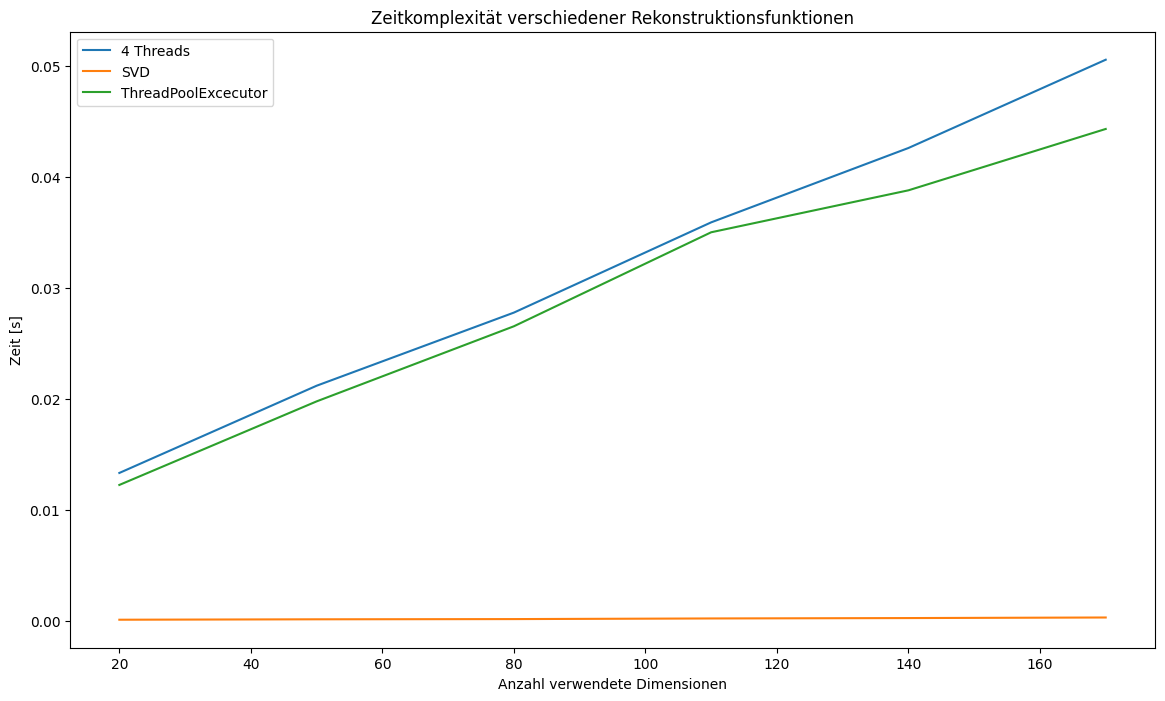

In [258]:
plt.plot(dfs["r1"].k, dfs["r1"].time, label="4 Threads")
plt.plot(svd_df.k, svd_df.time, label="SVD")
plt.plot(dfs["r2"].k, dfs["r2"].time, label="ThreadPoolExcecutor")

plt.legend()
plt.title("Zeitkomplexität verschiedener Rekonstruktionsfunktionen")
plt.ylabel("Zeit [s]")
plt.xlabel("Anzahl verwendete Dimensionen")
plt.plot()
plt.show()

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Wie die Visualisierung der Laufzeiten oben zeigt, lohnt es sich in diesem Fall nicht, Threads zu benutzen. Die Rekonstruktion der SVD kann direkt in einem Schritt, wie in der Beispielfunktion implementiert, durchgeführt werden. Der Rechenaufwand ist zu klein, die Verwendung von Threads lohnt sich nicht. Wäre der Rechenaufwand grösser könnte es je nach Anwendungsbeispiel sinnvoll sein, Threads zu verwenden.</font>

1. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Eine gute Möglichkeit wäre die Aufteilung von mehreren Bildern auf unterschiedliche Threads. Der Rechenaufwand pro Bild ist höher als der eines einzelnen Rekonstruktionsschritt. Für alle anderen Schritte, die keinen grossen Rechenaufwand mit sich bringen, lohnt es sich nicht, diese auf mehreren Threads aufzurufen. </font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>
Die manuelle Ausführung des Threadings ist nicht unbedingt langsamer als ein Thread-Pool-Executor. Es kann theoretisch genau die gleiche Performance erreicht werden. Bei der manuellen Ausführung müssen selbst Locks, Semaphoren und Conditions erstellt werden, um zu vermeiden, dass Fehler entstehen. Thread-Pool-Executors haben diese Funktionalität integriert und können einfacher verwendet werden. Das Problem entsteht nur, weil die Threads alle im gleichen Prozess laufen, was bedeutet, dass sie sich den gleichen Adress- und Speicherraum teilen. Beim Multiprocessing werden mehrere Prozesse erstellt, wodurch keine Konflikte entstehen. 

Multiprocessing ist generell schneller, wenn es um CPU-intensive Aufgaben geht. Multithreading ist schneller, wenn es um IO-intensive Aufgaben geht.
</font>